In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils.dataset_processing_utils as dputil

SEED = 42
np.random.seed(SEED)

In [3]:
crime_counts_df = dputil.load_dataset("unodc_drug_crime_counts.xlsx", header_row=0)

### *unodc_drug_crime_counts* dataset

In this dataset, we can extract the number of incidents of trafficking and possession of illicit drugs per country and for each year between 2018-2022. Furthermore, it also provides additional drill-downs into drug-types and different subgroups in the population - differentiating between male and female culprits, and also taking into account juveniles.
  In this section we will clean and re-order the data, and provide some analyses on the subgroups mentioned above.

#### overview features
Let us firstly take another look at the raw data as it was provided by UNODC

In [4]:
crime_counts_df.columns

Index(['Region', 'SubRegion', 'Country', 'campaign', 'Year', 'Type of offence',
       'Drug', 'Calculated total', 'Reported total', 'Males', 'Females',
       'Adults', 'Juveniles', 'Unknown/Other/ Third/Intersex',
       'Specify year if other', 'Adults: 18 and older',
       'Juveniles: under 18 years old', 'msCode'],
      dtype='object')

In [5]:
crime_counts_df.sample(10, random_state=SEED)

,Region,SubRegion,Country,campaign,Year,Type of offence,Drug,Calculated total,Reported total,Males,Females,Adults,Juveniles,Unknown/Other/ Third/Intersex,Specify year if other,Adults: 18 and older,Juveniles: under 18 years old,msCode
1079,Europe,Western and Central Europe,Greece,ARQ2020,2020,Offences related to drug trafficking,Any Illicit drugs,3347,3347.0,2819.0,298.0,3289.0,58.0,230.0,NaN,Yes,Yes,GRC
405,Europe,Eastern Europe,Republic of Moldova,ARQ2022,2022,Other drug-related offences,Any Illicit drugs,102,102.0,88.0,14.0,100.0,2.0,NaN,NaN,Yes,Yes,MDA
1493,Oceania,Australia and New Zealand,Australia,HIST2019,2019,Offences related to drug use and/or drug posse...,Cannabis-type,48431,39492.0,39758.0,8673.0,NaN,NaN,NaN,NaN,NaN,Yes,AUS
239,Oceania,Australia and New Zealand,New Zealand,HIST2018,2018,Offences related to drug trafficking,Hallucinogens,28,28.0,24.0,4.0,NaN,NaN,NaN,NaN,NaN,Yes,NZL
610,Americas,South America,Paraguay,ARQ2020,2020,Offences related to drug trafficking,Any Illicit drugs,337,337.0,274.0,63.0,293.0,11.0,NaN,NaN,Yes,Yes,PRY
99,Americas,South America,Bolivia (Plurinational State of),ARQ2021,2021,Other drug-related offences,Any Illicit drugs,6,6.0,5.0,0.0,6.0,0.0,1.0,NaN,Yes,Yes,BOL
1145,Americas,North America,Mexico,HIST2018,2018,Offences related to drug trafficking,Cannabis-type,4869,4869.0,4568.0,301.0,NaN,NaN,NaN,NaN,NaN,Yes,MEX
297,Americas,South America,Ecuador,HIST2019,2019,Offences related to drug trafficking,Cannabis-type,50,50.0,46.0,4.0,NaN,NaN,NaN,NaN,NaN,Yes,ECU
932,Americas,South America,Uruguay,HIST2018,2018,Offences related to drug trafficking,Cannabis-type,1607,1607.0,1260.0,347.0,NaN,NaN,NaN,NaN,NaN,NaN,URY
275,Africa,East Africa,Mauritius,HIST2018,2018,Offences related to drug trafficking,Sedatives and tranquillizers,41,41.0,40.0,1.0,NaN,NaN,NaN,NaN,NaN,Yes,MUS


In terms of relevant variables, we see the following as the values of interest:
- *Country* (will be changed to `country`): our main way to merge the datasets. Also is a part of what we define a population by.
- *Year* (will be changed to `year`): The 2nd part of the definition of a population. An integral part of our temporal analysis.
- *Drug* (will be changed to `drug_group`): Is the counterpart of `drug_name` in the seizures dataset, will be part of our analysis and later dismissed when we merge the above datasets together (as it'll be taken from the *seizures* dataset).
- *Type of offence* (will be changed to `offence_type`): differentiates between possession for use by a single too few person use (`Offences related to drug use and/or drug possession`) and more major volume of drugs possession - for sale, production or trafficking (`Offences related to drug trafficking`). The first might correlate to the treatment data, and the other to the seizures' data. We will demonstrate their behaviour across regions, gender and years. There is also a `Other drug-related offences` value that we'll have to see whether it could be ignored.
-  *Males*, *Females*, *Adults*, *Juveniles* and *Unknown...*: These are the variables that indicate the annual amount of incidents for a drug in a country. When summed together, they're represented by the *Calculated total* variable. We will see whether it is necessary to keep these values separated or they won't provide any useful information, and we'll use the aggregated version (by looking at the amount of null values for example). Additionally, when we'll merge the datasets into a singular dataframe, the values will be normalized by the country's population for that year, and will become *incidents per capita*.



In contrast - the following variables will be lightly used or not used at all:
- *Region* and *SubRegion*: Is the exact same as in the seizure dataset, we will use these variables for analysis, but then it'll be dismissed as we'll use the previous dataset's values.
- *campaign*: This is another way to represent the year.
- *Reported total*: This aggregated variable does not align as the sum of other variables, which raises the question we do they define a 'reported' incident. We prefer to aggregate the variables mentioned above ourselves, therefore we see no use for this column.
- *specify year if other*: This column probably tries to align with camping and does not have much non-null values anyway.
- *Adults 18 and older* and *Juveniles under 18...*: these binary values indicate the definitions of a juvenile for each country, but we will try to be agnostic to this definition.
- *msCode*: a country's symbol. We'll use `country` instead.


In [6]:
edited_crime_counts_df = crime_counts_df.rename(columns={
    "Country": "country",
    "Region": "region",
    "Year": "year",
    "SubRegion": "sub_region",
    "Type of offence": "offence_type",
    "Drug": "drug_group",
    "Males": "males_cases",
    "Females": "females_cases",
    "Adults": "adults_cases",
    "Juveniles": "juveniles_cases",
    "Unknown/Other/ Third/Intersex": "other_cases"
})
edited_crime_counts_df = edited_crime_counts_df[["region", "sub_region", "country", "year", "offence_type", "drug_group", "males_cases", "females_cases", "adults_cases", "juveniles_cases", "other_cases"]]

edited_crime_counts_df['region'] = edited_crime_counts_df.apply(lambda x: x['sub_region'] if "America" in x["sub_region"] else x["region"], axis=1)
edited_crime_counts_df['region'] = edited_crime_counts_df.apply(lambda x: "Central America" if "Americas" in x["region"] else x["region"], axis=1)

edited_crime_counts_df.sample(10, random_state=SEED)

,region,sub_region,country,year,offence_type,drug_group,males_cases,females_cases,adults_cases,juveniles_cases,other_cases
1079,Europe,Western and Central Europe,Greece,2020,Offences related to drug trafficking,Any Illicit drugs,2819.0,298.0,3289.0,58.0,230.0
405,Europe,Eastern Europe,Republic of Moldova,2022,Other drug-related offences,Any Illicit drugs,88.0,14.0,100.0,2.0,NaN
1493,Oceania,Australia and New Zealand,Australia,2019,Offences related to drug use and/or drug posse...,Cannabis-type,39758.0,8673.0,NaN,NaN,NaN
239,Oceania,Australia and New Zealand,New Zealand,2018,Offences related to drug trafficking,Hallucinogens,24.0,4.0,NaN,NaN,NaN
610,South America,South America,Paraguay,2020,Offences related to drug trafficking,Any Illicit drugs,274.0,63.0,293.0,11.0,NaN
99,South America,South America,Bolivia (Plurinational State of),2021,Other drug-related offences,Any Illicit drugs,5.0,0.0,6.0,0.0,1.0
1145,North America,North America,Mexico,2018,Offences related to drug trafficking,Cannabis-type,4568.0,301.0,NaN,NaN,NaN
297,South America,South America,Ecuador,2019,Offences related to drug trafficking,Cannabis-type,46.0,4.0,NaN,NaN,NaN
932,South America,South America,Uruguay,2018,Offences related to drug trafficking,Cannabis-type,1260.0,347.0,NaN,NaN,NaN
275,Africa,East Africa,Mauritius,2018,Offences related to drug trafficking,Sedatives and tranquillizers,40.0,1.0,NaN,NaN,NaN


#### Trafficking vs. Possession cases

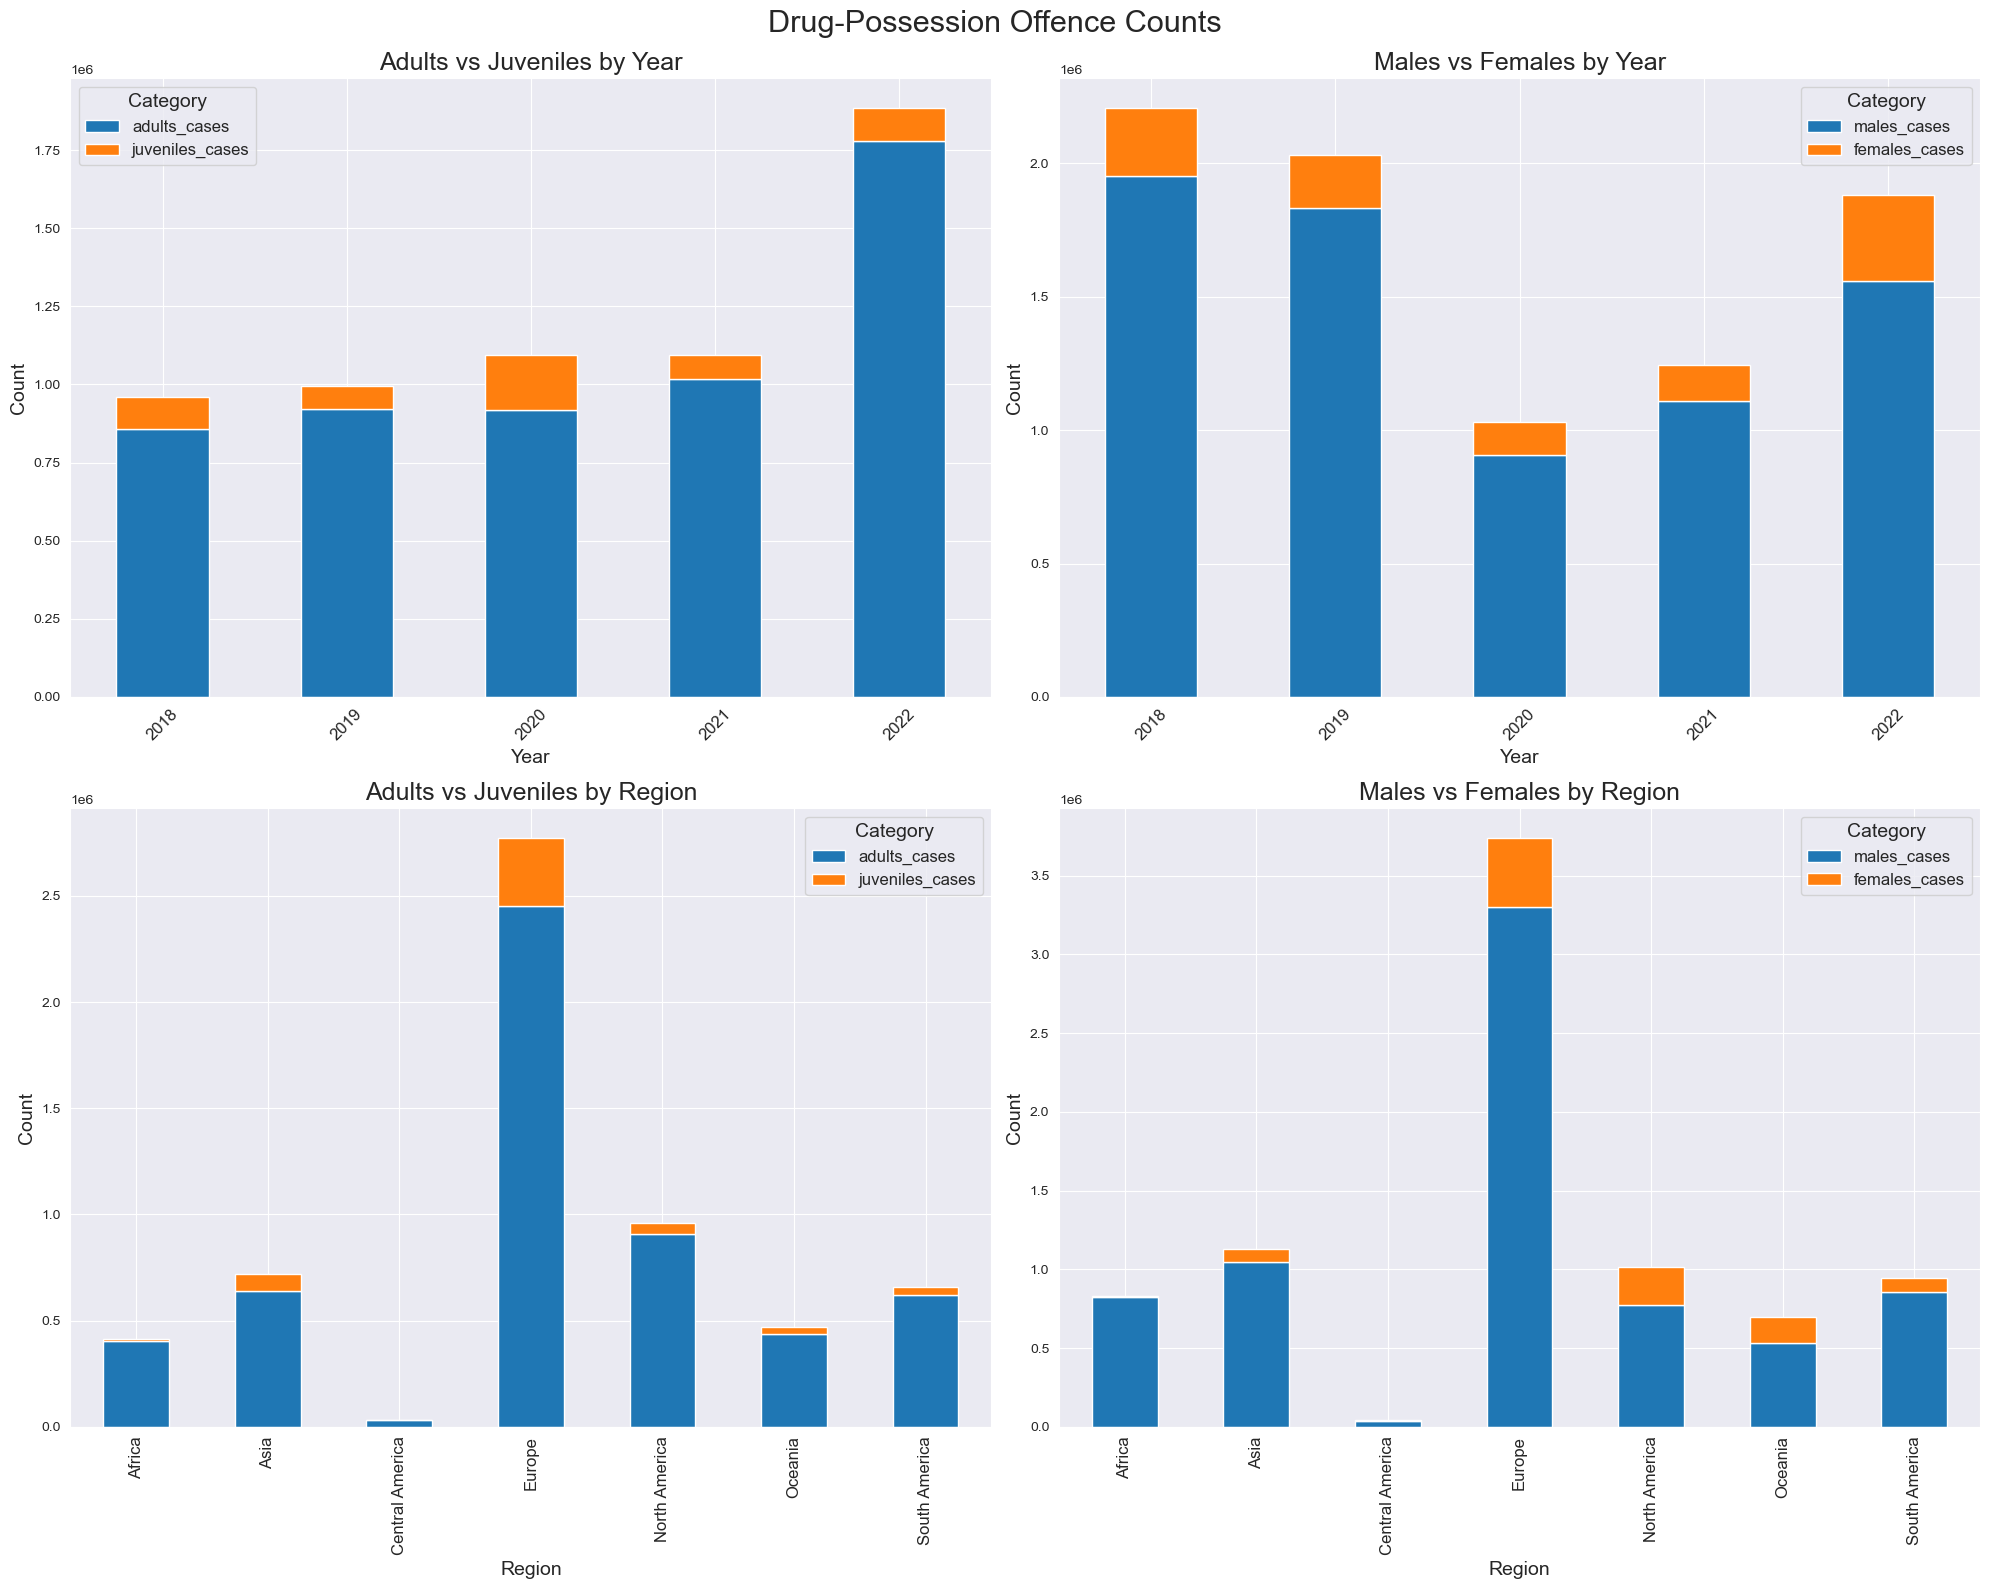

In [28]:
# Convert relevant columns to numeric, coercing errors
# Using the correct column names identified in the previous step
for col in ['males_cases', 'females_cases', 'adults_cases', 'juveniles_cases', 'year']:
    edited_crime_counts_df[col] = pd.to_numeric(edited_crime_counts_df[col], errors='coerce')

# Filter for the specific offence type
drug_offences_df = edited_crime_counts_df[edited_crime_counts_df['offence_type'] == 'Offences related to drug use and/or drug possession']

# Prepare data for subplots

# Subplot 1 & 2: Aggregated by year
agg_year_adult_juvenile = drug_offences_df.groupby('year')[['adults_cases', 'juveniles_cases']].sum().fillna(0)
agg_year_male_female = drug_offences_df.groupby('year')[['males_cases', 'females_cases']].sum().fillna(0)

# Subplot 3 & 4: Aggregated by region
agg_region_adult_juvenile = drug_offences_df.groupby('region')[['adults_cases', 'juveniles_cases']].sum().fillna(0)
agg_region_male_female = drug_offences_df.groupby('region')[['males_cases', 'females_cases']].sum().fillna(0)

# Create the four subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Drug-Possession Offence Counts', y=0.99, fontsize=22)

ax1, ax2, ax3, ax4 = axes.flatten()

# Subplot 1: Adults vs Juveniles by Year
agg_year_adult_juvenile.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Adults vs Juveniles by Year', fontsize=18)
ax1.set_ylabel('Count', fontsize=14)
ax1.set_xlabel('Year', fontsize=14)
ax1.tick_params(axis='x', rotation=45, labelsize=12)
ax1.legend(title='Category', fontsize=12, title_fontsize=14)

# Subplot 2: Males vs Females by Year
agg_year_male_female.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Males vs Females by Year', fontsize=18)
ax2.set_ylabel('Count', fontsize=14)
ax2.set_xlabel('Year', fontsize=14)
ax2.tick_params(axis='x', rotation=45, labelsize=12)
ax2.legend(title='Category', fontsize=12, title_fontsize=14)

# Subplot 3: Adults vs Juveniles by Region
agg_region_adult_juvenile.plot(kind='bar', stacked=True, ax=ax3)
ax3.set_title('Adults vs Juveniles by Region', fontsize=18)
ax3.set_ylabel('Count', fontsize=14)
ax3.set_xlabel('Region', fontsize=14)
ax3.tick_params(axis='x', rotation=90, labelsize=12)
ax3.legend(title='Category', fontsize=12, title_fontsize=14)

# Subplot 4: Males vs Females by Region
agg_region_male_female.plot(kind='bar', stacked=True, ax=ax4)
ax4.set_title('Males vs Females by Region', fontsize=18)
ax4.set_ylabel('Count', fontsize=14)
ax4.set_xlabel('Region', fontsize=14)
ax4.tick_params(axis='x', rotation=90, labelsize=12)
ax4.legend(title='Category', fontsize=12, title_fontsize=14)

plt.tight_layout() # Adjust layout to prevent title overlap
plt.show()

Now the same for drug trafficking:

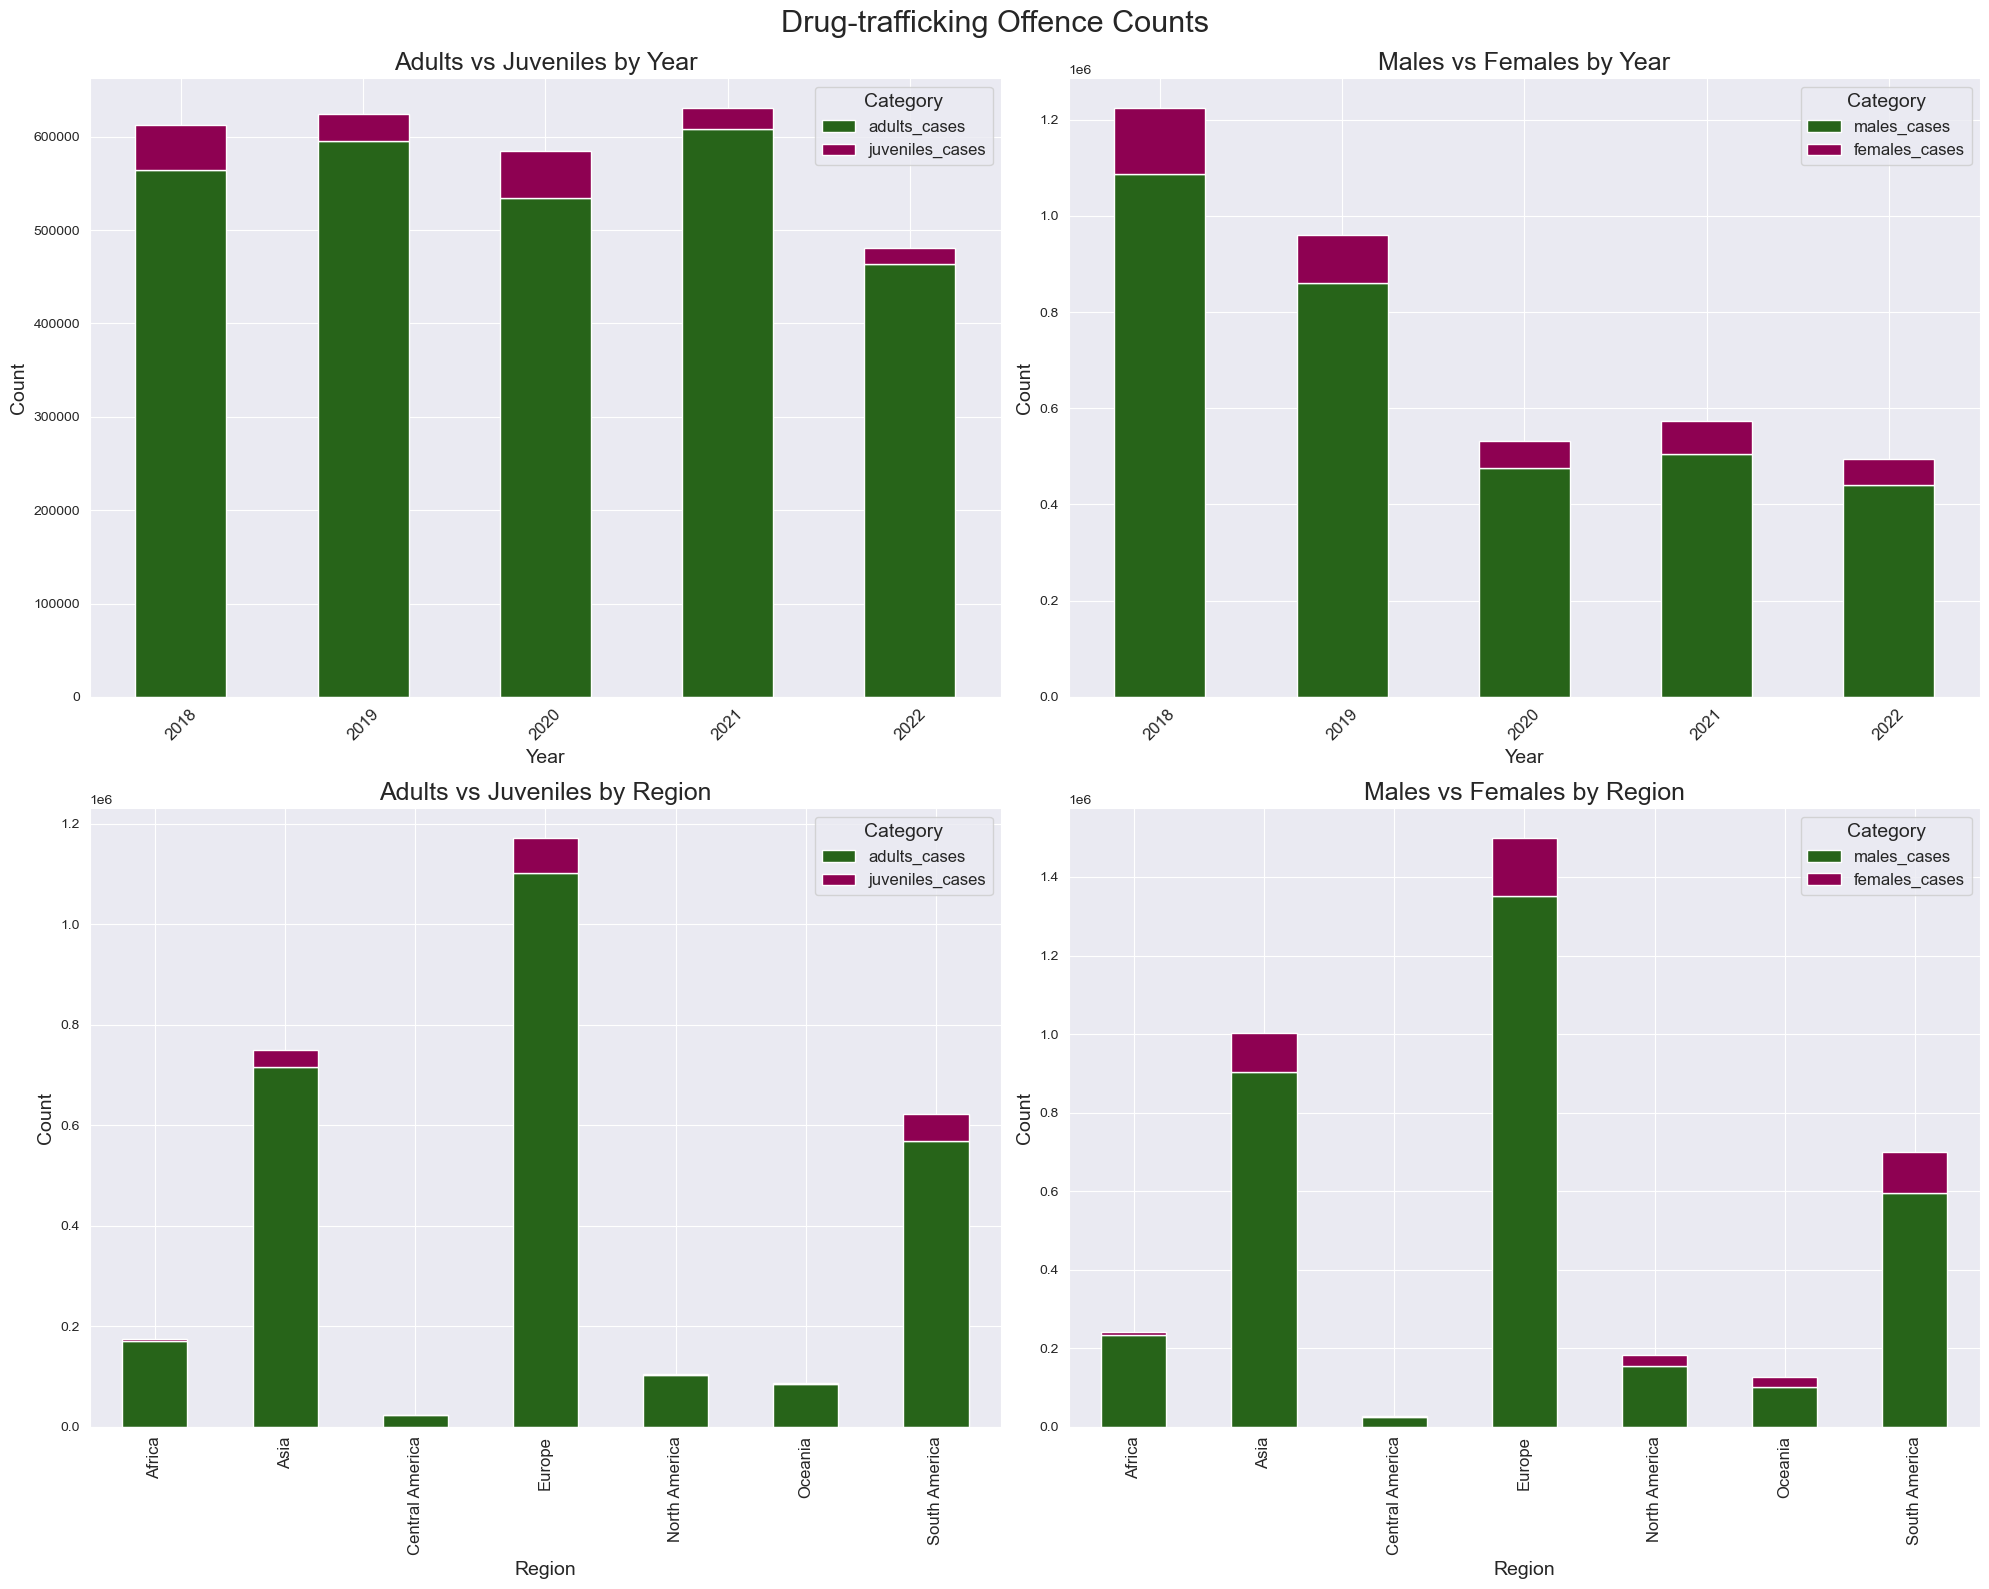

In [29]:
# Filter for the specific offence type
drug_offences_df = edited_crime_counts_df[edited_crime_counts_df['offence_type'] == 'Offences related to drug trafficking']

# Prepare data for subplots

# Subplot 1 & 2: Aggregated by year
agg_year_adult_juvenile = drug_offences_df.groupby('year')[['adults_cases', 'juveniles_cases']].sum().fillna(0)
agg_year_male_female = drug_offences_df.groupby('year')[['males_cases', 'females_cases']].sum().fillna(0)

# Subplot 3 & 4: Aggregated by region
agg_region_adult_juvenile = drug_offences_df.groupby('region')[['adults_cases', 'juveniles_cases']].sum().fillna(0)
agg_region_male_female = drug_offences_df.groupby('region')[['males_cases', 'females_cases']].sum().fillna(0)

# Create the four subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Drug-trafficking Offence Counts', y=0.99, fontsize=22)

ax1, ax2, ax3, ax4 = axes.flatten()

# Subplot 1: Adults vs Juveniles by Year
agg_year_adult_juvenile.plot(kind='bar', stacked=True, ax=ax1, cmap='PiYG_r')
ax1.set_title('Adults vs Juveniles by Year', fontsize=18)
ax1.set_ylabel('Count', fontsize=14)
ax1.set_xlabel('Year', fontsize=14)
ax1.tick_params(axis='x', rotation=45, labelsize=12)
ax1.legend(title='Category', fontsize=12, title_fontsize=14)

# Subplot 2: Males vs Females by Year
agg_year_male_female.plot(kind='bar', stacked=True, ax=ax2, cmap='PiYG_r')
ax2.set_title('Males vs Females by Year', fontsize=18)
ax2.set_ylabel('Count', fontsize=14)
ax2.set_xlabel('Year', fontsize=14)
ax2.tick_params(axis='x', rotation=45, labelsize=12)
ax2.legend(title='Category', fontsize=12, title_fontsize=14)

# Subplot 3: Adults vs Juveniles by Region
agg_region_adult_juvenile.plot(kind='bar', stacked=True, ax=ax3, cmap='PiYG_r')
ax3.set_title('Adults vs Juveniles by Region', fontsize=18)
ax3.set_ylabel('Count', fontsize=14)
ax3.set_xlabel('Region', fontsize=14)
ax3.tick_params(axis='x', rotation=90, labelsize=12)
ax3.legend(title='Category', fontsize=12, title_fontsize=14)

# Subplot 4: Males vs Females by Region
agg_region_male_female.plot(kind='bar', stacked=True, ax=ax4, cmap='PiYG_r')
ax4.set_title('Males vs Females by Region', fontsize=18)
ax4.set_ylabel('Count', fontsize=14)
ax4.set_xlabel('Region', fontsize=14)
ax4.tick_params(axis='x', rotation=90, labelsize=12)
ax4.legend(title='Category', fontsize=12, title_fontsize=14)

plt.tight_layout() # Adjust layout to prevent title overlap
plt.show()

|And finally for different drug types:

In [30]:
drug_offences_df['drug_group'].unique()

array(['Other opioids not under international control',
       'Any Illicit drugs', 'Opioids', 'Hallucinogens', 'ATS',
       'Other substances not under int. control', 'Plant-based NPS',
       'Other miscellaneous', 'Pharmaceutical opioids', 'Cocaine-type',
       'Ecstasy-type substances', 'Other Plant-based substances',
       'Non-specified', 'Non-specified substances not under int. control',
       'GBL', 'Cannabis-type', 'Methamphetamine', 'Benzodiazepines',
       'Multiple Drugs', 'Other stimulants',
       'Sedatives and tranquillizers',
       'Ketamine and phencyclidine-type substances', 'Crack', 'Heroin',
       'GHB', 'Other types of cannabis', 'Other NPS',
       'Coca paste/cocaine base', 'Marijuana (herb)', 'Hashish (resin)'],
      dtype=object)

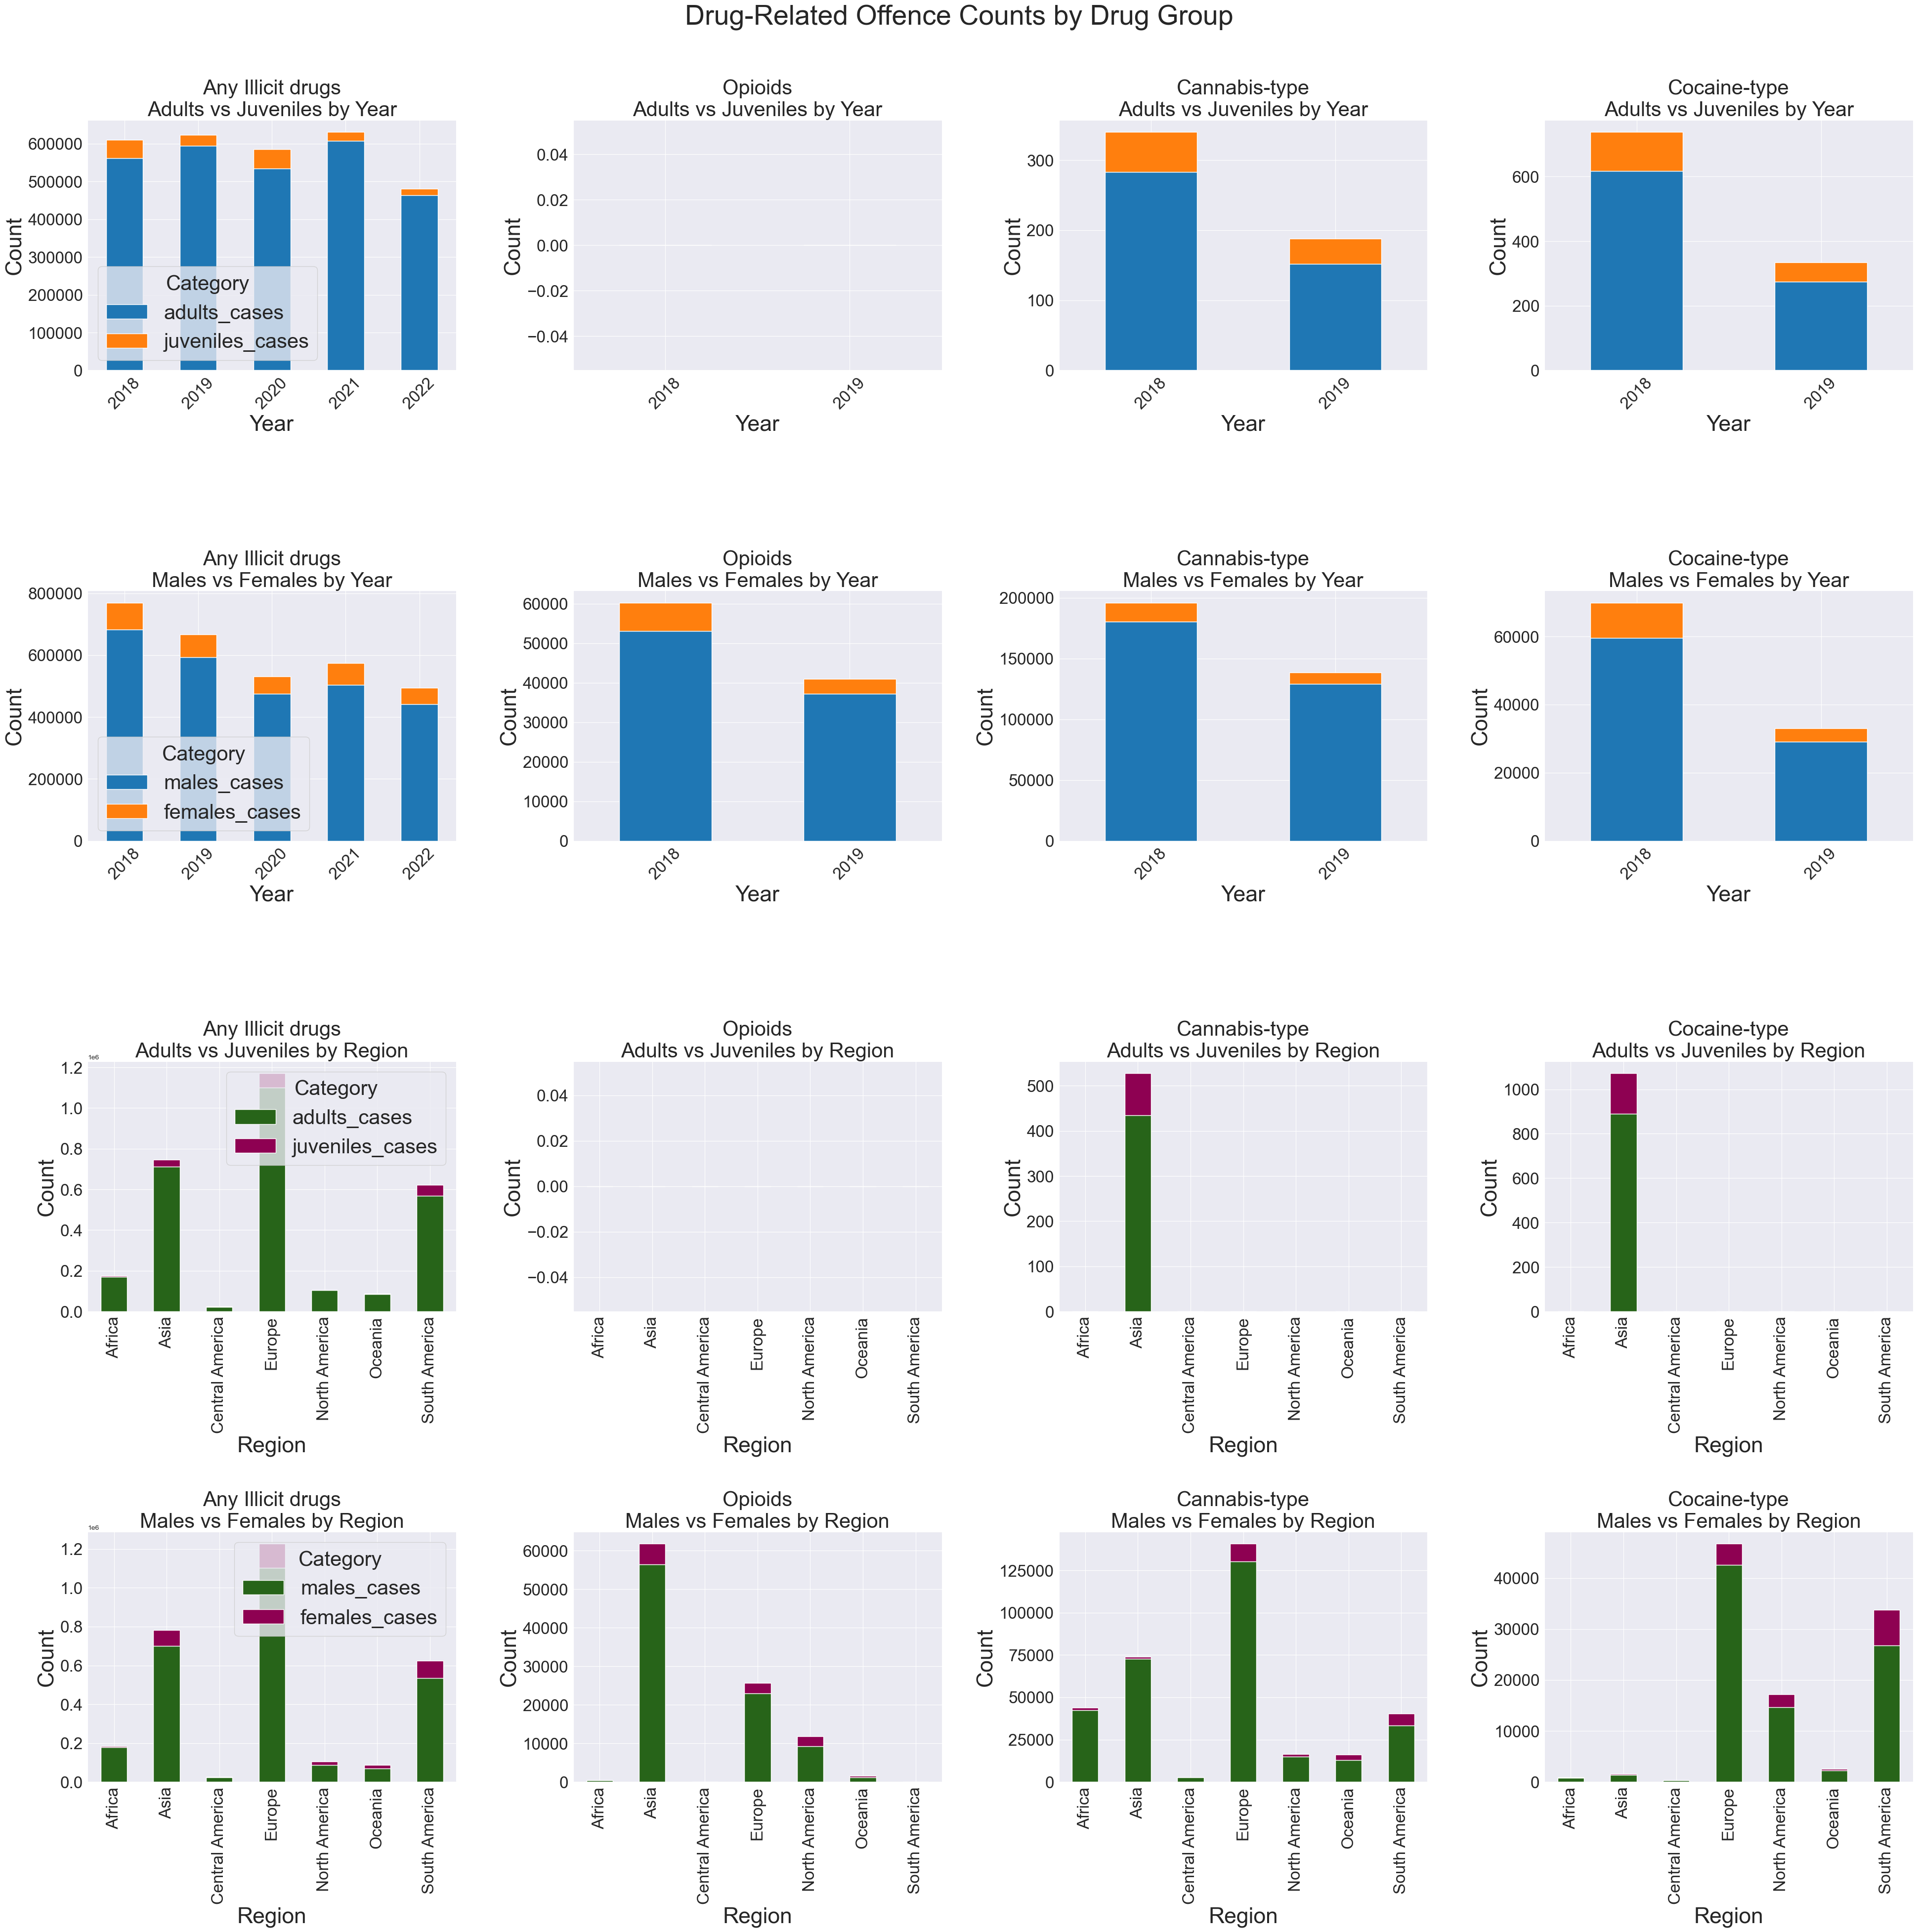

In [31]:
# Get unique drug groups
selected_drug_groups = ['Any Illicit drugs', 'Opioids', 'Cannabis-type', 'Cocaine-type']
num_drug_groups = len(selected_drug_groups)

# Create a figure with 4 rows and N columns (N = number of drug groups)
fig, axes = plt.subplots(4, num_drug_groups, figsize=(40, 40)) # Adjust figsize as needed
fig.suptitle('Drug-Related Offence Counts by Drug Group', y=0.99, fontsize=40)

# Iterate through each drug group and create a column of plots
for col_idx, drug_group in enumerate(selected_drug_groups):
    # Filter data for the current drug group
    current_drug_group_df = drug_offences_df[drug_offences_df['drug_group'] == drug_group]

    # Prepare data for subplots for the current drug group

    # Aggregated by year
    agg_year_adult_juvenile = current_drug_group_df.groupby('year')[['adults_cases', 'juveniles_cases']].sum().fillna(0)
    agg_year_male_female = current_drug_group_df.groupby('year')[['males_cases', 'females_cases']].sum().fillna(0)

    # Aggregated by region
    agg_region_adult_juvenile = current_drug_group_df.groupby('region')[['adults_cases', 'juveniles_cases']].sum().fillna(0)
    agg_region_male_female = current_drug_group_df.groupby('region')[['males_cases', 'females_cases']].sum().fillna(0)

    # Plotting for the current drug group column

    # Subplot Row 0: Adults vs Juveniles by Year
    ax0 = axes[0, col_idx] if num_drug_groups > 1 else axes[0]
    agg_year_adult_juvenile.plot(kind='bar', stacked=True, ax=ax0)
    ax0.set_title(f'{drug_group}\nAdults vs Juveniles by Year', fontsize=30)
    ax0.set_ylabel('Count', fontsize=32)
    ax0.set_xlabel('Year', fontsize=32)
    ax0.tick_params(axis='x', rotation=45, labelsize=24)
    ax0.tick_params(axis='y', labelsize=24)
    if col_idx == 0: # Only show legend for the first column to avoid redundancy
        ax0.legend(title='Category', fontsize=30, title_fontsize=30)
    else:
        ax0.legend().set_visible(False)


    # Subplot Row 1: Males vs Females by Year
    ax1 = axes[1, col_idx] if num_drug_groups > 1 else axes[1]
    agg_year_male_female.plot(kind='bar', stacked=True, ax=ax1)
    ax1.set_title(f'{drug_group}\nMales vs Females by Year', fontsize=30)
    ax1.set_ylabel('Count', fontsize=32)
    ax1.set_xlabel('Year', fontsize=32)
    ax1.tick_params(axis='x', rotation=45, labelsize=24)
    ax1.tick_params(axis='y', labelsize=24)
    if col_idx == 0:
        ax1.legend(title='Category', fontsize=30, title_fontsize=30)
    else:
        ax1.legend().set_visible(False)

    # Subplot Row 2: Adults vs Juveniles by Region
    ax2 = axes[2, col_idx] if num_drug_groups > 1 else axes[2]
    agg_region_adult_juvenile.plot(kind='bar', stacked=True, ax=ax2, cmap='PiYG_r')
    ax2.set_title(f'{drug_group}\nAdults vs Juveniles by Region', fontsize=30)
    ax2.set_ylabel('Count', fontsize=32)
    ax2.set_xlabel('Region', fontsize=32)
    ax2.tick_params(axis='x', rotation=90, labelsize=24)
    ax2.tick_params(axis='y', labelsize=24)
    if col_idx == 0:
        ax2.legend(title='Category', fontsize=30, title_fontsize=30)
    else:
        ax2.legend().set_visible(False)

    # Subplot Row 3: Males vs Females by Region
    ax3 = axes[3, col_idx] if num_drug_groups > 1 else axes[3]
    agg_region_male_female.plot(kind='bar', stacked=True, ax=ax3, cmap='PiYG_r')
    ax3.set_title(f'{drug_group}\nMales vs Females by Region', fontsize=30)
    ax3.set_ylabel('Count', fontsize=32)
    ax3.set_xlabel('Region', fontsize=32)
    ax3.tick_params(axis='x', rotation=90, labelsize=24)
    ax3.tick_params(axis='y', labelsize=24)
    if col_idx == 0:
        ax3.legend(title='Category', fontsize=30, title_fontsize=30)
    else:
        ax3.legend().set_visible(False)

plt.tight_layout(pad=5)
plt.show()

From the three figures above we can infer the following:
- Females and juveniles are underrepresented. This could be for multiple reasons, but the main issue is that age and gender are not really factors, especially when there is a large bias and not a lot of recorded incidents (in the cases of adults vs. juveniles)
- The trends we saw in the seizures dataset of different drug types across different continents is also consistent in the last figure, with opioids being prevalent in Asia and Cocaine in Europe and the Americas. However, we see some missing information with some of the drug types and the age categories. Furthermore, much more concerning is that drug-type specific information, which only seem to exist in 2018 to 2019. This might limit our drug-type specific models.

As we see that we are missing data - we'd like to see the magnitude for each of the variables:

<Figure size 1000x600 with 0 Axes>

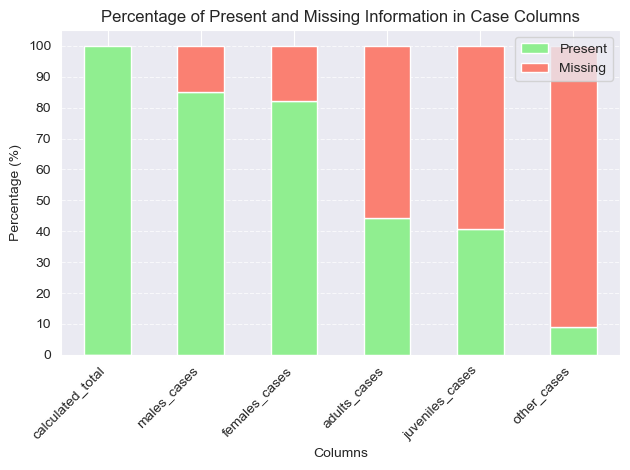

In [32]:
# Calculate the percentage of missing values for each column
nulls_df = edited_crime_counts_df[['males_cases', 'females_cases', 'adults_cases', 'juveniles_cases', 'other_cases']].copy()
nulls_df["calculated_total"] = crime_counts_df["Calculated total"]
nulls_df = nulls_df[['calculated_total', 'males_cases', 'females_cases', 'adults_cases', 'juveniles_cases', 'other_cases']]
missing_percentage = (nulls_df.isnull().sum() / len(edited_crime_counts_df)) * 100

# Calculate the percentage of present values for each column
present_percentage = 100 - missing_percentage

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Present': present_percentage,
    'Missing': missing_percentage
})

# Create a stacked bar chart
plt.figure(figsize=(10, 6))
plot_df.plot(kind='bar', stacked=True, color=['lightgreen', 'salmon'])
plt.title('Percentage of Present and Missing Information in Case Columns')
plt.xlabel('Columns')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.yticks(range(0, 101, 10)) # Set y-ticks from 0 to 100 in steps of 10
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

From the Percentages we see above, we unfortunately cannot rely solely on the gender or age cases for aggregation, since probably not all countries had reported this information. Therefore, we consider the *calculated total* as the variable we choose as an input for the model.

In [33]:
edited_crime_counts_df["calculated_total"] = crime_counts_df["Calculated total"]
# remove all other numerical variable columns
edited_crime_counts_df = edited_crime_counts_df.drop(columns=['adults_cases', 'juveniles_cases', 'other_cases'])
edited_crime_counts_df["crime_count_gender_ratio"] = dputil.calc_ratio(edited_crime_counts_df["females_cases"], edited_crime_counts_df["males_cases"])
edited_crime_counts_df = edited_crime_counts_df.drop(columns=['females_cases', 'males_cases'])